In [1]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

import json
import os
import glob
import pickle
from itertools import combinations
import gc
import time

import warnings
warnings.filterwarnings("ignore")

/home/tran/miniconda3/envs/compgan/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_ROOT = "../data/compgan_dataset/"

train_data_file_name_ = "train_data{}.npy"
train_label_file_name_ = "train_label{}.npy"
test_data_file_name_ = "test_data{}.npy"
test_label_file_name_ = "test_label{}.npy"

TRAIN_FOLDER_PATH = os.path.join(DATA_ROOT, "train")
TEST_FOLDER_PATH = os.path.join(DATA_ROOT, "test")
RESULT_FOLDER_PATH = os.path.join(DATA_ROOT, "results")

assert os.path.isdir(TRAIN_FOLDER_PATH) and os.path.isdir(TEST_FOLDER_PATH)
os.makedirs(RESULT_FOLDER_PATH, exist_ok=True)

data_files = sorted(glob.glob(os.path.join(TRAIN_FOLDER_PATH, train_data_file_name_.format("*"))))
print(data_files)
print(len(data_files))

['../data/compgan_dataset/train/train_data0.npy', '../data/compgan_dataset/train/train_data1.npy', '../data/compgan_dataset/train/train_data10.npy', '../data/compgan_dataset/train/train_data11.npy', '../data/compgan_dataset/train/train_data12.npy', '../data/compgan_dataset/train/train_data13.npy', '../data/compgan_dataset/train/train_data14.npy', '../data/compgan_dataset/train/train_data15.npy', '../data/compgan_dataset/train/train_data2.npy', '../data/compgan_dataset/train/train_data3.npy', '../data/compgan_dataset/train/train_data4.npy', '../data/compgan_dataset/train/train_data5.npy', '../data/compgan_dataset/train/train_data6.npy', '../data/compgan_dataset/train/train_data7.npy', '../data/compgan_dataset/train/train_data8.npy', '../data/compgan_dataset/train/train_data9.npy']
16


In [3]:
USER_NUM = 16
assert USER_NUM == len(data_files)
STANDARDIZE = False

In [4]:
# important

label_list = ['歩行(平地)',
 '歩行(階段)',
 'ベッド上での起き上がり',
 'ベッド椅子間の乗り移り(立つ)',
 'ベッド椅子間の乗り移り(立たない)',
 '立ち座り',
 '座位保持・座位バランス',
 '立位保持・立位バランス',
 '関節可動域増大訓練(肩)',
 '関節可動域増大訓練(股関節)']

label_dict = dict(enumerate(label_list))

In [5]:
# important
eng_label_dict = dict(zip(
    label_list,
    ['Walking', 'Upstair', 'Bed_Standup', 'Change_Bed', 'Change_Bed_Standup', 'Sit_Down', 'Sit', 'Stand', 'Shoulder_Exercise', 'Hip_Exercise']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

In [6]:
test_user = 0

In [7]:
def load_train_test(test_user):
    train_data_file_name = train_data_file_name_.format(test_user)
    train_label_file_name = train_label_file_name_.format(test_user)
    test_data_file_name = test_data_file_name_.format(test_user)
    test_label_file_name = test_label_file_name_.format(test_user)

    train_data_file_path = os.path.join(TRAIN_FOLDER_PATH, train_data_file_name)
    train_label_file_path = os.path.join(TRAIN_FOLDER_PATH, train_label_file_name)
    test_data_file_path = os.path.join(TEST_FOLDER_PATH, test_data_file_name)
    test_label_file_path = os.path.join(TEST_FOLDER_PATH, test_label_file_name)

    train_data, train_label = np.load(train_data_file_path), np.load(train_label_file_path)
    test_data, test_label = np.load(test_data_file_path), np.load(test_label_file_path)

    if STANDARDIZE:
        l, s, d, w = train_data.shape
        train_data_reshape = train_data.reshape(l, s * d, w).transpose(0,2,1).reshape(-1, s * d)
    
        l_t, s_t, d_t, w_t = test_data.shape
        test_data_reshape = test_data.reshape(l_t, s_t * d_t, w_t).transpose(0,2,1).reshape(-1, s_t * d_t)
    
        sc = StandardScaler()
        train_data_reshape_norm = sc.fit_transform(train_data_reshape)
        test_data_reshape_norm = sc.transform(test_data_reshape)
    
        train_data_reshape_back = train_data_reshape_norm.reshape(l, w, s * d)
        test_data_reshape_back = test_data_reshape_norm.reshape(l_t, w_t, s_t * d_t)
    else:
        l, s, d, w = train_data.shape
        train_data_reshape_back = train_data.reshape(l, s * d, w).transpose(0,2,1)

        l_t, s_t, d_t, w_t = test_data.shape
        test_data_reshape_back = test_data.reshape(l_t, s_t * d_t, w_t).transpose(0,2,1)

    return train_data_reshape_back, train_label, test_data_reshape_back, test_label

In [8]:
# test
train_data, train_label, test_data, test_label = load_train_test(test_user)

In [9]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(6361, 256, 42)
(6361,)
(214, 256, 42)
(214,)


In [10]:
feature_num = train_data.shape[-1]

In [11]:
class CustomDataset(Dataset):
    def __init__(self, feature_data, label_data, missing_sensor_id_list=None):
        self.features = feature_data
        self.label = label_data
        
        if missing_sensor_id_list is not None:
            for missing_sensor_id in missing_sensor_id_list:
                self.features[:, :, missing_sensor_id*6:(missing_sensor_id+1)*6] = 0

        assert len(self.features) == len(self.label), "features len is not equal to label len"
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        label = self.label[idx]
        return x, int(label)

In [12]:
def get_train_test_dataset(test_user, missing_sensor_id_list, echo=0):
    if echo: 
        print("***********Start get_train_test_dataset***********")
        print("missing_sensor_id_list:", missing_sensor_id_list)
    
    train_dataset_concat_list = []
    for user in range(USER_NUM):
        if user == test_user:
            if echo: print("test_user", user)
            train_data, train_label, test_data, test_label = load_train_test(user)
            test_dataset = CustomDataset(test_data, test_label, missing_sensor_id_list=missing_sensor_id_list)
    
        else:
            if echo: print("train_user", user)
            train_data, train_label, test_data, test_label = load_train_test(user)
            train_dataset = CustomDataset(train_data, train_label, missing_sensor_id_list=missing_sensor_id_list)
            train_dataset_concat_list.append(train_dataset)

    concat_train_dataset = torch.utils.data.ConcatDataset(train_dataset_concat_list)
    if not echo: print("***********get_train_test_dataset completed***********")
    return concat_train_dataset, test_dataset

In [13]:
def create_dataset_for_missing_sensor_number(test_user, missing_sensor_numbers, echo=0):
    if echo: print("****************Start create_dataset_for_missing_sensor_number", test_user, missing_sensor_numbers, "****************")
    train_dataset_list = []
    val_dataset_list = []
    test_dataset_list = []
    
    for missing_count in range(missing_sensor_numbers + 1):
        for missing_index in combinations(range(7), missing_count):

            dataset, test_dataset = get_train_test_dataset(test_user=test_user, missing_sensor_id_list=missing_index, echo=echo)
            train_size = int(0.8 * len(dataset))
            val_size = len(dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

            train_dataset_list.append(train_dataset)
            val_dataset_list.append(val_dataset)
            test_dataset_list.append(test_dataset)

    del dataset, test_dataset, train_dataset, val_dataset
    gc.collect()
    
    train_dataset = torch.utils.data.ConcatDataset(train_dataset_list)
    val_dataset = torch.utils.data.ConcatDataset(val_dataset_list)
    test_dataset = torch.utils.data.ConcatDataset(test_dataset_list)
    if echo: print("****************Completed create_dataset_for_missing_sensor_number****************")

    return train_dataset, val_dataset, test_dataset
        

In [14]:
# test
# train_dataset, val_dataset, test_dataset = create_dataset_for_missing_sensor_number(test_user=0, missing_sensor_numbers=0, echo=1)

In [15]:
# test
# train_dataloader = DataLoader(
#     train_dataset, 
#     batch_size=8,
#     num_workers=0, # number of subprocesses to use for data loading
#     shuffle=True)

# val_dataloader = DataLoader(
#     train_dataset, 
#     batch_size=8,
#     num_workers=0, # number of subprocesses to use for data loading
#     shuffle=False)

In [16]:
# next(train_dataloader.__iter__())[0].shape

## model definition

In [17]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

In [18]:
class LSTM_Attention_Model(pl.LightningModule):
    model_name = "LSTM_Attention_Model"
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 200, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)
        

In [19]:

class LSTMModel(pl.LightningModule):
    model_name = "LSTMModel"
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=2,
                          batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)

        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn(x)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)

        self.all_pred = test_pred_labels
        self.all_test = y

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss)

In [20]:
class Fixed_LSTM_Attention_Model(pl.LightningModule):
    model_name = "Fixed_LSTM_Attention_Model"
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.save_hyperparameters()
        self.example_input_array = torch.Tensor(1024, 200, input_size)
        
        self.rnn1 = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention1 = SelfAttention(
            input_dim=hidden_size)

        self.rnn2 = nn.LSTM(input_size=hidden_size, 
                          hidden_size=hidden_size,
                          num_layers=1,
                          batch_first=True)
        
        self.attention2 = SelfAttention(
            input_dim=hidden_size
        )

        self.rnn3 = nn.LSTM(input_size=hidden_size, 
                  hidden_size=hidden_size,
                  num_layers=1,
                  batch_first=True)
        
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
        self.all_test = []
        self.all_pred = []
        
    def forward(self, x):
        activation, _ = self.rnn1(x)
        activation = self.attention1(activation)
        activation, _ = self.rnn2(activation)
        activation = self.attention2(activation)
        activation, _ = self.rnn3(activation)

        b, _, _ = activation.size()
        
        lstm_output = activation[:,-1,:].view(b,-1)
        
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=0.0005)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.float()
        # 1. Forward pass
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("train_loss", loss, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        X, y = batch
        X = X.float()
        y = y
    
        # 1. Forward pass
        test_pred_logits = self.forward(X)

        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc = ((test_pred_labels == y).sum().item()/len(test_pred_labels))
        self.log("test_acc", test_acc)
        
        self.all_pred = test_pred_labels
        self.all_test = y
        
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        X, y = batch
        X = X.float()
        y = y
        
        y_pred = self.forward(X)
        # 2. Calculate  and accumulate loss
        loss = F.cross_entropy(y_pred, y)
        
        self.log("val_loss", loss, prog_bar=True)
        

In [21]:
use_model = Fixed_LSTM_Attention_Model
use_model.model_name

'Fixed_LSTM_Attention_Model'

In [22]:
model = use_model()
summary(model)

Layer (type:depth-idx)                   Param #
Fixed_LSTM_Attention_Model               --
├─LSTM: 1-1                              81,920
├─SelfAttention: 1-2                     --
│    └─Linear: 2-1                       16,512
│    └─Linear: 2-2                       16,512
│    └─Linear: 2-3                       16,512
│    └─Softmax: 2-4                      --
├─LSTM: 1-3                              132,096
├─SelfAttention: 1-4                     --
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       16,512
│    └─Softmax: 2-8                      --
├─LSTM: 1-5                              132,096
├─Sequential: 1-6                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14

In [23]:
batch_size = 1024
patience = 50
# missing_sensor_numbers = 0
all_test_pred = {}
start_timer = time.perf_counter()
missing_index = ()

# missing sensors number is the number of missing sensor, we loop it through 7 sensors
for missing_sensor_numbers in [0]: ## Changed for no missing sensor
    print(f"start learning missing_sensor_numbers = {missing_sensor_numbers}")
    
    all_test = []
    all_pred = []

    # kfold_train_test_index_list = [kfold_train_test_index_list[0]]

    for i in range(16): ## Changed for user 2 only
        print(f"\n*************training on User{i}*************")

        # ## Changed for no CV
        # train_data, train_label, test_data, test_label = load_train_test(i)
        # test_dataset = CustomDataset(test_data, test_label, missing_sensor_id_list=[])
        # dataset = CustomDataset(train_data, train_label, missing_sensor_id_list=[])
        
        # train_size = int(0.8 * len(dataset))
        # val_size = len(dataset) - train_size
        # train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        train_dataset, val_dataset, test_dataset = create_dataset_for_missing_sensor_number(i, missing_sensor_numbers)
        
        train_dataloader = DataLoader(
            train_dataset, 
            batch_size=batch_size,
            num_workers=4, # number of subprocesses to use for data loading
            shuffle=True)

        val_dataloader = DataLoader(
            val_dataset, 
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        test_dataloader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            num_workers=2, # number of subprocesses to use for data loading
            shuffle=False)

        model = use_model(hidden_size=128, input_size=feature_num, output_size=len(label_list))

        tb_logger = TensorBoardLogger(".")

        trainer = pl.Trainer(
            logger=tb_logger,
            callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
        )
        trainer.fit(model, train_dataloader, val_dataloader)
        trainer.test(model, test_dataloader)

        all_test.extend(model.all_test)
        all_pred.extend(model.all_pred)
            
        all_test_pred[i] = (all_test, all_pred)
    
        os.makedirs(os.path.join(RESULT_FOLDER_PATH, "99"), exist_ok=True)
        with open(os.path.join(RESULT_FOLDER_PATH, "99", f"Testonly_00_all_test_pred_user_{i}_{missing_sensor_numbers}_{model.model_name}.pkl"), "wb") as f:
            pickle.dump(all_test_pred[i], f)

print("Executed Time:", time.perf_counter() - start_timer)


start learning missing_sensor_numbers = 0

*************training on User0*************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


***********get_train_test_dataset completed***********


You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-11-04 18:47:05.214440: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 18:47:05.370149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-04


*************training on User1*************
***********get_train_test_dataset completed***********


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | In sizes         | Out sizes                                           
-----------------------------------------------------------------------------------------------------------------------
0 | rnn1       | LSTM          | 88.1 K | [1024, 200, 42]  | [[1024, 200, 128], [[1, 1024, 128], [1, 1024, 128]]]
1 | attention1 | SelfAttention | 49.5 K | [1024, 200, 128] | [1024, 200, 128]                                    
2 | rnn2       | LSTM          | 132 K  | [1024, 200, 128] | [[1024, 200, 128], [[1, 1024, 128], [1, 1024, 128]]]
3 | attention2 | SelfAttention | 49.5 K | [1024, 200, 128] | [1024, 200, 128]                                    
4 | rnn3       | LSTM          | 132 K  | [1024, 200, 128] | [[1024, 200, 128], [[1, 1024, 128], [1, 1024, 128]]]
5

Epoch 0:   3%|█▍                                                 | 2/73 [00:00<00:20,  3.40it/s, v_num=2685, train_loss=2.350]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



*************training on User2*************



KeyboardInterrupt



In [25]:
missing_sensor_numbers = 0

all_test_pred = {}
for i in range(5):
    with open(os.path.join(RESULT_FOLDER_PATH, "99", f"Testonly_{missing_sensor_numbers:02}_all_test_pred_user_{i}_{missing_sensor_numbers}_{use_model.model_name}.pkl"), "rb") as f:
        all_test_pred[i] = pickle.load(f)

In [41]:
all_test_pred_result = ([], [])
for i in [4]:
    all_test_pred_result[0].extend(all_test_pred[i][0])
    all_test_pred_result[1].extend(all_test_pred[i][1])

print(len(all_test_pred_result[0]))

3207


<Axes: >

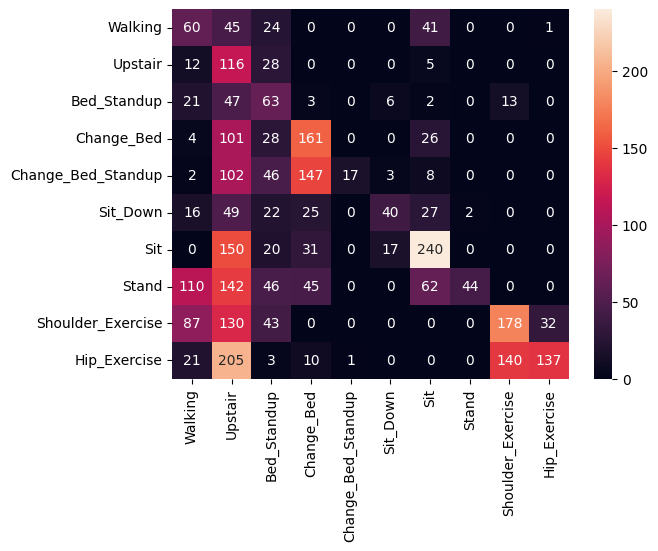

[rank: 0] Received SIGTERM: 15


In [42]:
all_test, all_pred = all_test_pred_result

# print("missing index", missing_index)
all_test_with_label = [label_list[i] for i in all_test]
all_pred_with_label = [label_list[i] for i in all_pred]

cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [28]:
from sklearn.metrics import accuracy_score, f1_score
all_test = list(map(lambda x: x.cpu().item(), all_test))
all_pred = list(map(lambda x: x.cpu().item(), all_pred))
print("accuracy:", accuracy_score(all_test, all_pred))
print("F1 score:", f1_score(all_test, all_pred, average='micro'))

accuracy: 0.40644276901987664
F1 score: 0.4064427690198767


In [29]:
# batch_size = 1024
# patience = 20
# # missing_sensor_numbers = 0
# all_test_pred = {}
# start_timer = time.perf_counter()
# # missing sensors number is the number of missing sensor, we loop it through 7 sensors
# for missing_sensor_numbers in [1,2,3,4,5,6]:
#     print(f"start learning missing_sensor_numbers = {missing_sensor_numbers}")
    
#     all_test = []
#     all_pred = []

#     # kfold_train_test_index_list = [kfold_train_test_index_list[0]]

#     for i in range(len(data_files)):
#         print(f"\n*************training on User{i}*************")

#         train_dataset, val_dataset, test_dataset = create_dataset_for_missing_sensor_number(i, missing_sensor_numbers)
        
#         train_dataloader = DataLoader(
#             train_dataset, 
#             batch_size=batch_size,
#             num_workers=4, # number of subprocesses to use for data loading
#             shuffle=True)

#         val_dataloader = DataLoader(
#             val_dataset, 
#             batch_size=batch_size,
#             num_workers=2, # number of subprocesses to use for data loading
#             shuffle=False)

#         test_dataloader = DataLoader(
#             test_dataset,
#             batch_size=batch_size,
#             num_workers=2, # number of subprocesses to use for data loading
#             shuffle=False)

#         model = use_model(hidden_size=128, input_size=feature_num, output_size=len(label_list))

#         tb_logger = TensorBoardLogger(".")

#         trainer = pl.Trainer(
#             logger=tb_logger,
#             callbacks=[EarlyStopping(monitor="val_loss", patience=patience, mode="min")],
#         )
#         trainer.fit(model, train_dataloader, val_dataloader)
#         trainer.test(model, test_dataloader)

#         all_test.extend(model.all_test)
#         all_pred.extend(model.all_pred)
            
#         all_test_pred[missing_index] = (all_test, all_pred)
    
#     os.makedirs(RESULT_FOLDER_PATH, exist_ok=True)
#     with open(os.path.join(RESULT_FOLDER_PATH, f"00_all_test_pred_{missing_sensor_numbers}_{model.model_name}.pkl"), "wb") as f:
#         pickle.dump(all_test_pred, f)

# print("Executed Time:", time.perf_counter() - start_timer)


In [ ]:
# for missing_sensor_numbers in range(1):
#     with open(os.path.join(RESULT_FOLDER_PATH, f"00_all_test_pred_{missing_sensor_numbers}_{use_model.model_name}.pkl"), "rb") as f:
#         all_test_pred = pickle.load(f)

#     if all_test_pred == 0:
#         missing_index = list(all_test_pred.keys())[0]
        
#         all_tall_test, all_pred = all_test_pred[missing_index]
        
#         # print("missing index", missing_index)
#         all_test_with_label = [label_list[i] for i in all_test]
#         all_pred_with_label = [label_list[i] for i in all_pred]
        
#         cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
#         sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')
#     else:
#         row_item = 2
#         fig, ax = plt.subplots(len(all_test_pred.keys()) // row_item + len(all_test_pred.keys()) % row_item, row_item, figsize=(13,28))
        
#         for idx, missing_index in enumerate(all_test_pred.keys()):
#             all_test, all_pred = all_test_pred[missing_index]
            
#             # print("missing index", missing_index)
#             all_test_with_label = [label_list[i] for i in all_test]
#             all_pred_with_label = [label_list[i] for i in all_pred]
            
#             cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
#             sns.heatmap(cf, ax=ax[idx//row_item][idx%row_item], annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')
#             ax[idx//row_item][idx%row_item].set_title(f"missing_index {missing_index} confusion matrix")
            
#     plt.savefig(os.path.join(RESULT_FOLDER_PATH, f"00_all_test_pred_{missing_sensor_numbers}_{use_model.model_name}.jpg"))

In [ ]:
# from sklearn.metrics import accuracy_score
# all_test = list(map(lambda x: x.cpu().item(), all_tall_test))
# all_pred = list(map(lambda x: x.cpu().item(), all_pred))
# accuracy_score(all_test, all_pred)